In [ ]:
""" 
NOₓ Imputation for Norwegian Passenger Cars Using COPERT
========================================================

Purpose
-------
This script imputes missing NOₓ emission values for Norwegian passenger cars
using COPERT emission factors combined with vehicle characteristics from the
REGTEK motor vehicle registry. The goal is to reconstruct NOₓ emissions for
older vehicle vintages and scrapped vehicles where observed emissions data
are missing, enabling analysis of fleet turnover and environmental impacts.

The script builds on upstream processing where CO₂ emissions have already
been imputed and OFV vehicle segments (`segment_ofv`) have been attached.
Vehicle segments are harmonized to COPERT passenger-car classes and imputed
where missing using engine power.

Inputs
------
- REGTEK vehicle registry (preprocessed upstream):
    * Euro standard codes
    * First registration date
    * Observed NOₓ emissions (mg/km; may be missing)
    * Engine power
    * Fuel type codes
    * OFV vehicle segment classification (`segment_ofv`)
- COPERT emission factor tables:
    * Passenger-car NOₓ emission factors by
      fuel type, vehicle segment, Euro standard, and technology

Method
------
1. Load REGTEK data restricted to passenger cars.
2. Harmonize Euro standards from REGTEK to COPERT-compatible classes:
    - Exclude heavy-duty Euro frameworks.
    - Impute missing Euro classes using first registration year.
    - Split Euro 6 into COPERT sub-phases based on registration year.
3. Load COPERT emission factor tables and restrict to passenger cars (M1).
4. Harmonize COPERT Euro standards and vehicle segments.
5. Map OFV passenger-car segments to COPERT segment classes and
   drop non-passenger vehicles.
6. Impute missing vehicle segments using a multinomial logistic regression
   based on engine power.
7. Harmonize fuel types between REGTEK and COPERT (petrol and diesel only).
8. Restrict COPERT data to NOₓ emission factors and valid fuel types.
9. Assess the relevance of COPERT technology classifications:
    - Compare NOₓ variation across technologies within
      Fuel × Segment × Euro cells.
    - Conclude that technology effects are small in most cases and
      omit technology from baseline NOₓ imputation.
10. Construct average NOₓ emission factors by
    Fuel × Segment × Euro class.
11. Merge COPERT NOₓ factors onto REGTEK vehicles.
12. Impute missing REGTEK NOₓ emissions using COPERT factors
    (g/km → mg/km conversion).
13. Force NOₓ emissions to zero for zero-emission vehicles.
14. Validate imputation by comparing observed REGTEK NOₓ values to
    COPERT-based estimates using scatter plots and ratio distributions.

Outputs
-------
- REGTEK_local_EFs.parquet:
    REGTEK dataset with imputed NOₓ emissions (`TEKN_NOX_UTSLIPP_MGPRKM`),
    harmonized Euro standards, fuel types, and vehicle segments.
- Diagnostic plots:
    * Observed vs. COPERT NOₓ scatter plot
    * Distribution of observed-to-COPERT NOₓ ratios
    """


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# ============================================================
# PATHS
# ============================================================
REGTEK_PATH = r"C:\Users\s15832\Documents\Project\weightproject2\Input\REGTEK_CO2_imputed.parquet"
COPERT_PATH = r"C:\Users\s15832\Documents\Project\weightproject2\Input\1_A_3_b_i_iv_Road_Transport_Appendix_4_Emission_Factors_Oct_2025.xlsx"
OUTPUT_PATH = r"C:\Users\s15832\Documents\Project\weightproject2\Output\REGTEK_local_EFs.parquet"
# ============================================================

In [2]:
# ============================================================
# LOAD REGTEK (already merged with OFV upstream)
# ============================================================

df = pd.read_parquet(
    REGTEK_PATH,
    columns=[
        "TEKN_EURONORM_NY",
        "TEKN_REG_F_G_N",
        "segment_ofv",
        "TEKN_MOTORYTELSE",
        "TEKN_SLAGVOLUM",
        "TEKN_DRIVSTOFF",
        "TEKN_NOX_UTSLIPP_MGPRKM",
    ],
)

print("REGTEK loaded:", df.shape)

REGTEK loaded: (7121936, 7)


In [3]:
print(df["TEKN_EURONORM_NY"].value_counts())

TEKN_EURONORM_NY
nan    1979548
6L     1227021
4L      797294
5L      726455
2L      599769
3L      589912
0       449389
1L      400886
U       344645
6T        1998
3T        1758
1T        1082
2T         846
5T         687
4T         592
ET          45
EEV          9
Name: count, dtype: int64


In [4]:
# ============================================================
# EURO STANDARD HARMONIZATION (REGTEK → COPERT, PASSENGER CARS)
# ============================================================
#
# Assumptions:
# 1) Dataset is already restricted to passenger cars (TEKN_KJTGRP == 101).
# 2) Euro codes ending with "T" denote heavy-duty Euro frameworks and are
#    NOT compatible with COPERT Passenger Car emission factors.
#    These vehicles are excluded, for now, rather than reclassified.
# 3) Missing or unknown Euro codes ("U", NaN) are imputed using
#    first registration year, following standard COPERT practice.
# 4) Euro 6 is split into COPERT sub-phases based on registration year,
#    as required for NOx emission factors.
#

# --------------------------------------------------
# 1. Remove heavy-duty Euro framework (xT)
#    xT = heavy-duty vehicles → not COPERT passenger cars
# --------------------------------------------------
mask_hdv = df["TEKN_EURONORM_NY"].astype(str).str.endswith("T", na=False)
df = df.loc[~mask_hdv].copy()

# --------------------------------------------------
# 2. Base Euro mapping from REGTEK codes (light-duty only)
# --------------------------------------------------
REGTEK_EURO_MAP = {
    # ----------------------------------
    # Light-duty passenger cars
    # ----------------------------------
    "1L": "Euro 1",
    "2L": "Euro 2",
    "3L": "Euro 3",
    "4L": "Euro 4",
    "5L": "Euro 5",
    "6L": "Euro 6",          # split later by year

    # ----------------------------------
    # Zero-emission vehicles
    # ----------------------------------
    "0":  "Zero emission",   # explicitly zero-emission (EV)

    # ----------------------------------
    # Special / explicit REGTEK labels
    # ----------------------------------
    "ET": "Euro 6 d-temp",
    "EEV": "EEV",

    # ----------------------------------
    # Unknown → impute by age
    # ----------------------------------
    "U":  np.nan,
}

df["euro_base"] = df["TEKN_EURONORM_NY"].map(REGTEK_EURO_MAP)

# --------------------------------------------------
# First registration year from REGTEK (YYYYMMDD → YYYY)
# --------------------------------------------------
df["reg_year"] = (
    pd.to_numeric(df["TEKN_REG_F_G_N"], errors="coerce") // 10000
).astype("Int64")

# --------------------------------------------------
# 3. Impute missing Euro class using registration year
#    Applies ONLY to true unknowns (U / NaN)
# --------------------------------------------------
miss = (
    df["euro_base"].isna()
    & df["reg_year"].notna()
)

df.loc[miss & (df["reg_year"] <= 1992), "euro_base"] = "Conventional"
df.loc[miss & (df["reg_year"].between(1993, 1996)), "euro_base"] = "Euro 1"
df.loc[miss & (df["reg_year"].between(1997, 2000)), "euro_base"] = "Euro 2"
df.loc[miss & (df["reg_year"].between(2001, 2005)), "euro_base"] = "Euro 3"
df.loc[miss & (df["reg_year"].between(2006, 2010)), "euro_base"] = "Euro 4"
df.loc[miss & (df["reg_year"].between(2011, 2015)), "euro_base"] = "Euro 5"
df.loc[miss & (df["reg_year"] >= 2016), "euro_base"] = "Euro 6"

# --------------------------------------------------
# 4. Split Euro 6 into COPERT phases (MANDATORY for NOx)
#    Zero-emission vehicles are excluded implicitly.
#    Table 2-2 in COPERT Manual, page 9.
# --------------------------------------------------
df["euro_copert"] = df["euro_base"]

mask6 = df["euro_base"].eq("Euro 6") & df["reg_year"].notna()

# Euro 6 a/b/c: up to 2018
df.loc[mask6 & (df["reg_year"] <= 2018), "euro_copert"] = "Euro 6 a/b/c"

# Euro 6 d-temp: 2019–2020
df.loc[mask6 & (df["reg_year"].between(2019, 2020)), "euro_copert"] = "Euro 6 d-temp"

# Euro 6 d/e: 2021+
df.loc[mask6 & (df["reg_year"] >= 2021), "euro_copert"] = "Euro 6 d/e"

# **Identify zero-emission vehicles**
mask_bev = df["euro_base"] == "Zero emission"


# --------------------------------------------------
# 6. Final sanity check: only COPERT-compatible Euro classes remain
# --------------------------------------------------
COPERT_EUROS = {
    "Conventional",
    "Euro 1",
    "Euro 2",
    "Euro 3",
    "Euro 4",
    "Euro 5",
    "Euro 6 a/b/c",
    "Euro 6 d-temp",
    "Euro 6 d/e",
    "EEV",
}

assert df.loc[~mask_bev, "euro_copert"].dropna().isin(COPERT_EUROS).all()

In [5]:
# ============================================================
# LOAD COPERT
# ============================================================
copert = pd.read_excel(
    COPERT_PATH,
    sheet_name="HOT_EMISSIONS_PARAMETERS"
)
print(copert["Category"].value_counts())
print("COPERT loaded:", copert.shape)

Category
Heavy Duty Trucks            30624
Buses                        16059
Passenger Cars                4452
Light Commercial Vehicles     1087
L-Category                    1055
Name: count, dtype: int64
COPERT loaded: (53277, 24)


In [6]:
# Restrict COPERT emission factors to Passenger Cars only
# (other vehicle categories use different emission functions)
copert["Category_clean"] = copert["Category"].str.strip().str.lower()
copert_pc = copert[copert["Category_clean"] == "passenger cars"].copy()
print(copert_pc.shape)

(4452, 25)


In [7]:
copert_pc = copert_pc.drop(columns=["Category_clean"])
print(copert_pc["Euro Standard"].value_counts())

Euro Standard
Euro 6 d/e               635
Euro 7                   635
Euro 6 d-temp            635
Euro 4                   552
Euro 6 a/b/c             522
Euro 5                   400
Euro 3                   231
Euro 1                   183
Euro 2                   183
Conventional             172
ECE 15/02                 48
PRE ECE                   48
ECE 15/00-01              48
ECE 15/04                 48
ECE 15/03                 48
Open Loop                 32
Improved Conventional     32
Name: count, dtype: int64


In [8]:
# ============================================================
# COPERT Euro Standard → canonical COPERT Euro classes
# (Euro 7 excluded: dataset snapshot Feb 2025)
# ============================================================

EURO_MAP_COPERT = {
    # --------------------------------------------------
    # Conventional / pre-Euro
    # --------------------------------------------------
    "Conventional": "Conventional",
    "PRE ECE": "Conventional",
    "ECE 15/00-01": "Conventional",
    "ECE 15/02": "Conventional",
    "ECE 15/03": "Conventional",
    "ECE 15/04": "Conventional",
    "Open Loop": "Conventional",
    "Improved Conventional": "Conventional",

    # --------------------------------------------------
    # Euro 1–5
    # --------------------------------------------------
    "Euro 1": "Euro 1",
    "Euro 2": "Euro 2",
    "Euro 3": "Euro 3",
    "Euro 4": "Euro 4",
    "Euro 5": "Euro 5",

    # --------------------------------------------------
    # Euro 6 phases (COPERT-defined)
    # --------------------------------------------------
    "Euro 6 a/b/c": "Euro 6 a/b/c",
    "Euro 6 d-temp": "Euro 6 d-temp",
    "Euro 6 d/e": "Euro 6 d/e",
}

copert_pc["euro_copert"] = copert_pc["Euro Standard"].map(EURO_MAP_COPERT)

assert copert_pc["euro_copert"].dropna().isin(EURO_MAP_COPERT.values()).all()

print(copert_pc["euro_copert"].value_counts())

euro_copert
Euro 6 d/e       635
Euro 6 d-temp    635
Euro 4           552
Euro 6 a/b/c     522
Conventional     476
Euro 5           400
Euro 3           231
Euro 1           183
Euro 2           183
Name: count, dtype: int64


In [9]:
# Sanity check the overlap before merging
set(df["euro_copert"].unique()) & set(copert_pc["euro_copert"].unique())

{'Conventional',
 'Euro 1',
 'Euro 2',
 'Euro 3',
 'Euro 4',
 'Euro 5',
 'Euro 6 a/b/c',
 'Euro 6 d-temp',
 'Euro 6 d/e'}

In [10]:
# segment_ofv     = original OFV classification
# segment_copert  = mapped COPERT passenger-car segment (observed only)
# segment         = final segment (observed + predicted)

In [11]:
df["segment_ofv"].unique()

array([None, 'SUV mellomklasse', 'SUV kompaktklasse', 'SUV store biler',
       'Kompaktklassen', 'SUV småbiler', 'Mellomklassen', 'Småbiler',
       'Flerbruk store biler', 'Minibiler', 'Flerbruk mellomklasse',
       'Store biler', 'Sport store biler', 'Sport kompaktklasse',
       'Flerbruk kompaktklasse', 'SUV luksusbiler', 'Terrengbiler',
       'Sport mellomklasse', 'Småvarebiler', 'Sport småbiler',
       'Sport luksusbiler', 'Flerbruk småbiler', 'Luksusbiler',
       'Pickuper', 'Mellomstore kassev/p', 'Andre',
       'Store kassev/pick-up', 'Flerbruk luksusbiler', 'Sport minibiler',
       'Stasjonsvogner', 'Flerbruksbiler'], dtype=object)

In [12]:
df["segment_ofv"].value_counts()

segment_ofv
Kompaktklassen            950378
Mellomklassen             789122
SUV mellomklasse          557129
Småbiler                  406698
SUV kompaktklasse         209717
SUV store biler           191777
Store biler               166543
Flerbruk kompaktklasse     92695
Minibiler                  72161
Flerbruk store biler       60414
Flerbruk mellomklasse      31752
Luksusbiler                25404
SUV luksusbiler            21195
SUV småbiler               16101
Sport mellomklasse         10892
Sport kompaktklasse         8465
Flerbruk småbiler           8325
Sport luksusbiler           7619
Terrengbiler                3670
Sport store biler           3389
Mellomstore kassev/p        2003
Andre                       1947
Sport småbiler              1594
Flerbruk luksusbiler         663
Pickuper                     419
Småvarebiler                 401
Stasjonsvogner               195
Sport minibiler               69
Store kassev/pick-up          62
Flerbruksbiler                4

In [13]:
copert_pc["Segment"].unique()

array(['Mini', 'Small', 'Medium', 'Large-SUV-Executive', '2-Stroke'],
      dtype=object)

In [14]:
copert_pc["Segment"].value_counts()

Segment
Large-SUV-Executive    1274
Medium                 1210
Small                  1210
Mini                    730
2-Stroke                 28
Name: count, dtype: int64

In [15]:
# --------------------------------------------------
# Define non-passenger cars (COPERT ≠ M1)
# --------------------------------------------------
# Non-passenger-car stuff (should be excluded)
# In the COPERT document, Passenger Cars = M1 vehicles only:
# Vehicles designed primarily to carry passengers
# Max 8 seats + driver
# Not vans, pickups, box vehicles, or multipurpose cargo vehicles
# Table 2-1: Definition of road vehicle categories, page 5, COPERT Manual
# --------------------------------------------------
NON_PC_SEGMENTS = {
    "Småvarebiler", # small vans
    "Mellomstore varebiler", # medium vans
    "Pickuper", # pickups
    "Mellomstore kassev/p", # medium box vans
    "Store kassev/pick-up", # large box vans / pickups
    "Flerbruksbiler", # multi-purpose vehicles
}

# Drop non-passenger cars (before any mapping or prediction)
mask_non_pc = df["segment_ofv"].isin(NON_PC_SEGMENTS)
print("Dropping non-passenger cars:", mask_non_pc.sum())

df = df.loc[~mask_non_pc].copy()


Dropping non-passenger cars: 2931


In [16]:
# Map remaining OFV passenger-car segments → COPERT segments
SEGMENT_MAP = {
    # --------------------------------------------------
    # Mini
    # --------------------------------------------------
    "Minibiler": "Mini",
    "Sport minibiler": "Mini",

    # --------------------------------------------------
    # Small
    # --------------------------------------------------
    "Småbiler": "Small",
    "SUV småbiler": "Small",
    "Sport småbiler": "Small",
    "Flerbruk småbiler": "Small",

    # --------------------------------------------------
    # Medium
    # --------------------------------------------------
    "Kompaktklassen": "Medium",
    "Mellomklassen": "Medium",
    "SUV kompaktklasse": "Medium",
    "SUV mellomklasse": "Medium",
    "Flerbruk kompaktklasse": "Medium",
    "Flerbruk mellomklasse": "Medium",
    "Sport kompaktklasse": "Medium",
    "Sport mellomklasse": "Medium",
    "Stasjonsvogner": "Medium",

    # --------------------------------------------------
    # Large / SUV / Executive
    # --------------------------------------------------
    "Store biler": "Large-SUV-Executive",
    "SUV store biler": "Large-SUV-Executive",
    "Luksusbiler": "Large-SUV-Executive",
    "SUV luksusbiler": "Large-SUV-Executive",
    "Sport store biler": "Large-SUV-Executive",
    "Sport luksusbiler": "Large-SUV-Executive",
    "Flerbruk store biler": "Large-SUV-Executive",
    "Flerbruk luksusbiler": "Large-SUV-Executive",
    "Terrengbiler": "Large-SUV-Executive",    

    "Andre": np.nan, # others
}

df["segment_copert"] = df["segment_ofv"].map(SEGMENT_MAP)

In [17]:
# Sanity checks
print(df["segment_copert"].value_counts(dropna=False))
print(df["segment_copert"].shape)

segment_copert
NaN                    3476030
Medium                 2650345
Large-SUV-Executive     480674
Small                   432718
Mini                     72230
Name: count, dtype: int64
(7111997,)


In [18]:
# Sanity check the overlap before merging
set(df["segment_copert"].unique()) & set(copert_pc["Segment"].unique())

{'Large-SUV-Executive', 'Medium', 'Mini', 'Small'}

In [19]:
# What did not map 
print(
    df.loc[df["segment_copert"].isna(), "segment_ofv"]
    .value_counts()
)


segment_ofv
Andre    1947
Name: count, dtype: int64


In [20]:
# COPERT segment encoding for the classifier
# M1: vehicles used for the carriage of passengers and comprising not more 
# than eight seats in addition to the driver. COPERT DOC Table 2-1, page 5.
segment_map = {
    "Mini": 0,
    "Small": 1,
    "Medium": 2,
    "Large-SUV-Executive": 3,
}

# Reverse mapping: numeric class → COPERT segment label (for decoding model predictions)
inv_map = {v: k for k, v in segment_map.items()}


In [21]:
# ============================================================
# SEGMENT IMPUTATION USING ENGINE POWER
# ============================================================
# Prepare numeric engine power once
df["power"] = pd.to_numeric(df["TEKN_MOTORYTELSE"], errors="coerce")

# Build training set
train = df[df["segment_copert"].notna()].copy()

X_train = train[["power"]]   #TEKN_MOTORYTELSE = "Engine power"
y_train = train["segment_copert"].map(segment_map)

mask_train = X_train["power"].notna() & y_train.notna()
X_train = X_train.loc[mask_train]
y_train = y_train.loc[mask_train]

if len(X_train) == 0:
    raise ValueError("Segment training set is empty after OFV → COPERT mapping.")

# Fit multinomial logistic regression
logit = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
)
logit.fit(X_train, y_train)

# This preserves observed segments.
df["segment"] = df["segment_copert"].copy()

#Predict missing segments
mask_missing = df["segment"].isna()

print(
    "Rows missing segment before prediction:",
    mask_missing.sum()
)

print(
    "Of those, missing engine power:",
    (mask_missing & df["power"].isna()).sum()
)

# Predict segments for missing using engine power
mask_ok = mask_missing & df["power"].notna()

df.loc[mask_ok, "segment"] = (
    pd.Series(
        logit.predict(df.loc[mask_ok, ["power"]]),
        index=df.loc[mask_ok].index
    )
    .map(inv_map)
)
print(
    "Rows missing segment after prediction:",
    df["segment"].isna().sum()
)

Rows missing segment before prediction: 3476030
Of those, missing engine power: 2348958
Rows missing segment after prediction: 2348958


In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# --------------------------------------------------
# AUC (multiclass, one-vs-rest) on training data
# --------------------------------------------------

# Predicted class probabilities on training set
y_train_proba = logit.predict_proba(X_train)

# Binarize true labels for multiclass AUC
classes = np.sort(y_train.unique())
y_train_bin = label_binarize(y_train, classes=classes)

# Compute macro-average AUC
auc_macro = roc_auc_score(
    y_train_bin,
    y_train_proba,
    average="macro",
    multi_class="ovr"
)

print(f"Training AUC (macro, OvR): {auc_macro:.3f}")


Training AUC (macro, OvR): 0.853


In [23]:
print(df["segment"].value_counts(dropna=False))
print(df["segment"].isna().sum())


segment
Medium                 3548038
NaN                    2348958
Large-SUV-Executive     585745
Small                   552070
Mini                     77186
Name: count, dtype: int64
2348958


In [24]:
df["TEKN_DRIVSTOFF"].value_counts()

TEKN_DRIVSTOFF
1            4061806
2            1664637
5             564251
5,5           297638
1,5           248786
nan           151437
1,5,5         103742
2,5            15417
5,5,5           3432
6                363
13               191
4                 84
3                 28
1,5,5,5           27
1,12              25
5,1               24
1,15              22
15                18
1,4               11
2,5,5              9
2,10               9
1,13               9
9                  8
1,1                4
1,5,5,5,5          3
11                 3
5,5,5,5            2
1,16               2
12                 1
2,2,5              1
2,5,5,5            1
1,18,19            1
6,5                1
1,1,5              1
1,16,17            1
1,1,5,5            1
1,18               1
Name: count, dtype: int64

In [25]:
copert_pc["Fuel"].unique()

array(['Petrol', 'Petrol Hybrid', 'Petrol PHEV ~ Petrol',
       'Petrol PHEV ~ Electricity', 'Diesel', 'Diesel PHEV ~ Diesel',
       'Diesel PHEV ~ Electricity', 'LPG Bifuel ~ LPG',
       'LPG Bifuel ~ Petrol', 'CNG Bifuel ~ CNG', 'CNG Bifuel ~ Petrol',
       'Battery electric'], dtype=object)

In [26]:
copert_pc["Fuel"].value_counts()

Fuel
Petrol                       1172
Petrol Hybrid                 648
Diesel                        600
LPG Bifuel ~ LPG              525
LPG Bifuel ~ Petrol           456
Petrol PHEV ~ Petrol          330
CNG Bifuel ~ CNG              312
CNG Bifuel ~ Petrol           264
Diesel PHEV ~ Diesel           84
Petrol PHEV ~ Electricity      33
Battery electric               16
Diesel PHEV ~ Electricity      12
Name: count, dtype: int64

In [27]:
# Define REGTEK → COPERT fuel mapping
FUEL_MAP = {
    "1": "Petrol",
    "2": "Diesel",
    "5": "Battery electric",
}
df["fuel_copert"] = df["TEKN_DRIVSTOFF"].map(FUEL_MAP)


In [28]:
# Check what you dropped
print(df["fuel_copert"].value_counts(dropna=False))

fuel_copert
Petrol              4061806
Diesel              1664637
NaN                  821303
Battery electric     564251
Name: count, dtype: int64


In [29]:
print(
    df.loc[df["fuel_copert"].isna(), "TEKN_DRIVSTOFF"]
    .value_counts()
    .head(10)
)

TEKN_DRIVSTOFF
5,5      297638
1,5      248786
nan      151437
1,5,5    103742
2,5       15417
5,5,5      3432
6           363
13          191
4            84
3            28
Name: count, dtype: int64


In [30]:
# Restrict COPERT fuels to the same
VALID_COPERT_FUELS = {
    "Petrol",
    "Diesel",
}

copert_pc = copert_pc[copert_pc["Fuel"].isin(VALID_COPERT_FUELS)].copy()

print(copert_pc["Fuel"].value_counts())


Fuel
Petrol    1172
Diesel     600
Name: count, dtype: int64


In [31]:
# Work on a copy of COPERT passenger-car data
copert_nox = copert_pc.copy()

# Normalize pollutant name (strip spaces, uppercase)
copert_nox["Pollutant_clean"] = copert_nox["Pollutant"].str.strip().str.upper()

# Keep NOx rows only
copert_nox = copert_nox[copert_nox["Pollutant_clean"] == "NOX"].copy()

# Convert NOx emission factor to numeric (g/km)
copert_nox["nox_ef_gpkm"] = pd.to_numeric(
    copert_nox["EF [g/km] or ECF [MJ/km] or #/km or #/kWh or g/kWh"],
    errors="coerce"
)

# Drop rows without a valid NOx emission factor
copert_nox = copert_nox[copert_nox["nox_ef_gpkm"].notna()].copy()

copert_nox.columns.tolist()


['Category',
 'Fuel',
 'Segment',
 'Euro Standard',
 'Technology',
 'Pollutant',
 'Mode',
 'Road Slope',
 'Load',
 'Min Speed [km/h]',
 'Max Speed [km/h]',
 'Alpha',
 'Beta',
 'Gamma',
 'Delta',
 'Epsilon',
 'Zita',
 'Hta',
 'Reduction Factor [%]',
 'Bio Reduction Factor [%]',
 '80',
 'EF [g/km] or ECF [MJ/km] or #/km or #/kWh or g/kWh',
 'Updated emission\n factors in v5.9',
 'Unnamed: 23',
 'euro_copert',
 'Pollutant_clean',
 'nox_ef_gpkm']

In [ ]:
# Assess whether COPERT NOx emission factors vary meaningfully by technology
# within Fuel × Segment × Euro standard cells. If variation is small,
# technology can be omitted from the baseline NOx imputation.

tech_variation = (
    copert_nox
    .groupby(["Fuel", "Segment", "euro_copert"])
    .agg(
        # Number of distinct technologies within each cell
        n_tech=("Technology", "nunique"),
        # Range and average of NOx emission factors across technologies
        ef_min=("nox_ef_gpkm", "min"),
        ef_max=("nox_ef_gpkm", "max"),
        ef_mean=("nox_ef_gpkm", "mean"),
    )
    .reset_index()
)

# Relative variation in NOx across technologies within each cell
# (normalized by the mean emission factor)
tech_variation["rel_range"] = (
    (tech_variation["ef_max"] - tech_variation["ef_min"])
    / tech_variation["ef_mean"]
)

# Restrict attention to cells with multiple technologies
multi_tech = tech_variation[tech_variation["n_tech"] > 1]

# Inspect cells with the largest technology-driven variation in NOx
multi_tech.sort_values("rel_range", ascending=False).head(20)


,Fuel,Segment,euro_copert,n_tech,ef_min,ef_max,ef_mean,rel_range
5,Diesel,Large-SUV-Executive,Euro 5,2,0.336637,0.480910,0.408774,0.352941
14,Diesel,Medium,Euro 5,2,0.336637,0.480910,0.408774,0.352941
19,Diesel,Mini,Euro 5,2,0.336637,0.480910,0.408774,0.352941
28,Diesel,Small,Euro 5,2,0.336637,0.480910,0.408774,0.352941
8,Diesel,Large-SUV-Executive,Euro 6 d/e,3,0.038473,0.038473,0.038473,0.000000
7,Diesel,Large-SUV-Executive,Euro 6 d-temp,3,0.048091,0.048091,0.048091,0.000000
6,Diesel,Large-SUV-Executive,Euro 6 a/b/c,3,0.396123,0.396123,0.396123,0.000000
16,Diesel,Medium,Euro 6 d-temp,3,0.048091,0.048091,0.048091,0.000000
15,Diesel,Medium,Euro 6 a/b/c,3,0.396123,0.396123,0.396123,0.000000
20,Diesel,Mini,Euro 6 a/b/c,3,0.396123,0.396123,0.396123,0.000000


In [33]:
(multi_tech["rel_range"] > 0.15).mean()
# rel_range < 0.05 (5%) → Technology irrelevant for NOx within each

np.float64(0.10256410256410256)

# Technology has limited impact on NOx conditional on Fuel × Segment × Euro.
# >90% of cases show <15% variation across technologies.
# Technology is therefore omitted from baseline NOx imputation.

In [94]:
# Average NOx emission factor per Fuel × Segment × Euro class (Technology ignored)
copert_nox_lookup = (
    copert_nox
    .groupby(["Fuel", "Segment", "euro_copert"], as_index=False)["nox_ef_gpkm"]
    .mean()
)

In [95]:
# Sanity check: ensure one unique NOx value per Fuel × Segment × Euro class
assert not copert_nox_lookup.duplicated(["Fuel","Segment","euro_copert"]).any()

In [96]:
# Normalize join keys (defensive, mandatory)
for col in ["fuel_copert", "segment", "euro_copert"]:
    df[col] = df[col].astype("string").str.strip()

for col in ["Fuel", "Segment", "euro_copert"]:
    copert_nox_lookup[col] = copert_nox_lookup[col].astype("string").str.strip()


In [97]:
df = df.merge(
    copert_nox_lookup,
    left_on=["fuel_copert", "segment", "euro_copert"],
    right_on=["Fuel", "Segment", "euro_copert"],
    how="left"
)

In [98]:
print(df.columns)   

Index(['TEKN_EURONORM_NY', 'TEKN_REG_F_G_N', 'segment_ofv', 'TEKN_MOTORYTELSE',
       'TEKN_SLAGVOLUM', 'TEKN_DRIVSTOFF', 'TEKN_NOX_UTSLIPP_MGPRKM',
       'euro_base', 'reg_year', 'euro_copert', 'segment_copert', 'power',
       'segment', 'fuel_copert', 'Fuel', 'Segment', 'nox_ef_gpkm'],
      dtype='object')


In [99]:
df["nox_copert_mgpkm"] = df["nox_ef_gpkm"] * 1000


In [100]:
mask_bev = df["euro_base"] == "Zero emission"
df.loc[mask_bev, "TEKN_NOX_UTSLIPP_MGPRKM"] = 0.0
print("BEVs forced to zero:", mask_bev.sum())

BEVs forced to zero: 449366


In [101]:
# ============================================================
# MISSING VALUE DETECTOR (ZERO IS VALID)
# ============================================================
def is_missing(s: pd.Series) -> pd.Series:
    mask = s.isna()
    if s.dtype == object:
        mask |= (
            s.astype(str)
             .str.strip()
             .str.upper()
             .isin(["", "NA", "N/A", "NULL", "NONE", "UNKNOWN"])
        )
    mask |= pd.to_numeric(s, errors="coerce").isna()
    return mask


In [102]:
mask_missing_before = is_missing(df["TEKN_NOX_UTSLIPP_MGPRKM"])

print(
    "Missing NOx before:",
    mask_missing_before.mean(),
    f"({mask_missing_before.sum()} rows)"
)



Missing NOx before: 0.5801907677970055 (4126315 rows)


In [103]:
print(
    "Rows with COPERT NOx available:",
    df["nox_copert_mgpkm"].notna().mean(),
    f"({df['nox_copert_mgpkm'].notna().sum()} rows)"
)
df['nox_copert_mgpkm'].nunique()

Rows with COPERT NOx available: 0.52608796094824 (3741536 rows)


18

In [104]:
# Freeze observation status before imputation for plotting later
df["nox_observed"] = ~is_missing(df["TEKN_NOX_UTSLIPP_MGPRKM"])

In [105]:
# # Impute missing REGTEK NOx
# # REGTEK: mg/km
# # COPERT: g/km
mask_impute = (
    mask_missing_before
    & df["nox_ef_gpkm"].notna()
)

df.loc[mask_impute, "TEKN_NOX_UTSLIPP_MGPRKM"] = (
    df.loc[mask_impute, "nox_copert_mgpkm"]
)

print(
    "Imputed via COPERT:",
    mask_impute.mean(),
    f"({mask_impute.sum()} rows)"
)

mask_missing_after = is_missing(df["TEKN_NOX_UTSLIPP_MGPRKM"])

print(
    "Missing NOx after:",
    mask_missing_after.mean(),
    f"({mask_missing_after.sum()} rows)"
)

Imputed via COPERT: 0.22047843945940923 (1568042 rows)
Missing NOx after: 0.3597123283375963 (2558273 rows)


Rows used for validation: 2173494


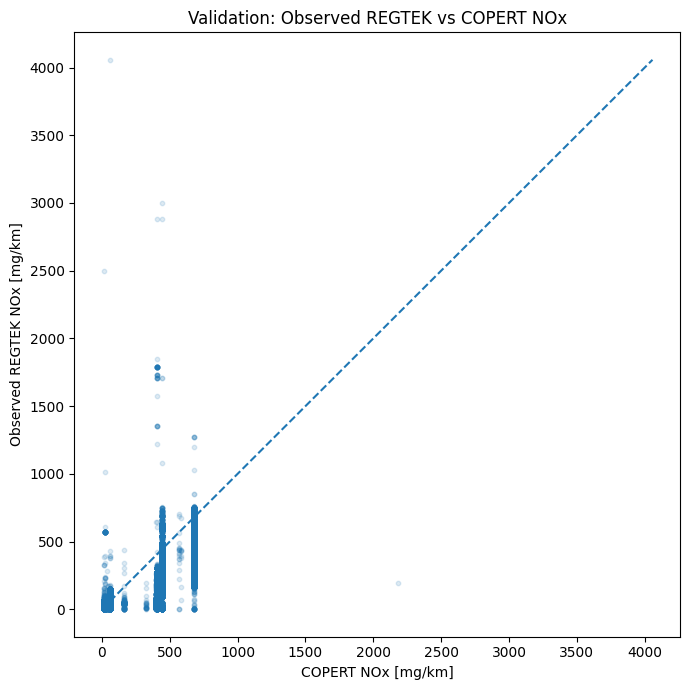

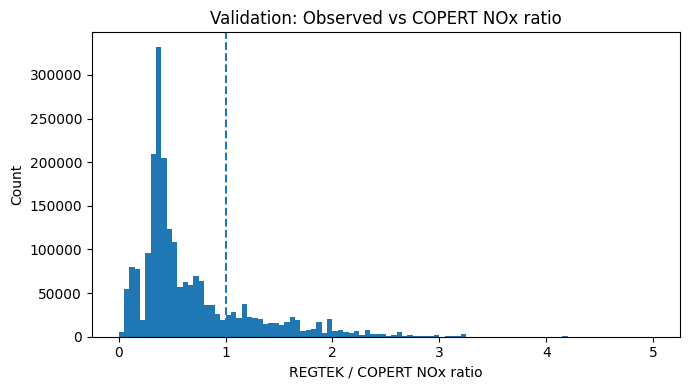

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# Use ONLY rows that were originally observed
# --------------------------------------------------
mask_validate = (
    df["nox_observed"]                      # observed before imputation
    & df["nox_copert_mgpkm"].notna()         # COPERT available
    & (df["nox_copert_mgpkm"] > 0)           # avoid division by zero
)

df_val = df.loc[mask_validate].copy()

print("Rows used for validation:", df_val.shape[0])

# Ensure numeric (defensive)
df_val["TEKN_NOX_UTSLIPP_MGPRKM"] = pd.to_numeric(
    df_val["TEKN_NOX_UTSLIPP_MGPRKM"], errors="coerce"
)
df_val["nox_copert_mgpkm"] = pd.to_numeric(
    df_val["nox_copert_mgpkm"], errors="coerce"
)

df_val = df_val.dropna(
    subset=["TEKN_NOX_UTSLIPP_MGPRKM", "nox_copert_mgpkm"]
)

# ==================================================
# 1. SCATTER: Observed vs COPERT NOx
# ==================================================
plt.figure(figsize=(7, 7))

plt.scatter(
    df_val["nox_copert_mgpkm"],
    df_val["TEKN_NOX_UTSLIPP_MGPRKM"],
    alpha=0.15,
    s=10
)

mx = max(
    df_val["nox_copert_mgpkm"].max(),
    df_val["TEKN_NOX_UTSLIPP_MGPRKM"].max()
)

plt.plot([0, mx], [0, mx], linestyle="--")

plt.xlabel("COPERT NOx [mg/km]")
plt.ylabel("Observed REGTEK NOx [mg/km]")
plt.title("Validation: Observed REGTEK vs COPERT NOx")

plt.tight_layout()
plt.show()

# ==================================================
# 2. HISTOGRAM: REGTEK / COPERT NOx ratio
# ==================================================
df_val["nox_ratio"] = (
    df_val["TEKN_NOX_UTSLIPP_MGPRKM"]
    / df_val["nox_copert_mgpkm"]
)

plt.figure(figsize=(7, 4))

plt.hist(
    df_val["nox_ratio"],
    bins=100,
    range=(0, 5)
)

plt.axvline(1.0, linestyle="--")

plt.xlabel("REGTEK / COPERT NOx ratio")
plt.ylabel("Count")
plt.title("Validation: Observed vs COPERT NOx ratio")

plt.tight_layout()
plt.show()
